In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('my_custom_style')
import pandas as pd
from sqlalchemy import create_engine
from datetime import date, timedelta
import calendar

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from itables import show
pd.options.display.max_rows = 31

engine = create_engine("sqlite:///c:\\ruby\\expense\\db\\development.sqlite3")
conn = engine.connect()
today = date.today()
today

datetime.date(2025, 2, 28)

In [3]:
sql = "SELECT C.id, C.name AS item, G.name AS kind, G.id FROM categories C \
       JOIN groups G ON group_id = G.id"
df_c = pd.read_sql(sql, conn)
df_c.head()

,id,item,kind,id
0,1,Books & Software,Edutainment,3
1,2,CCF,Luxury,5
2,3,Cigarette,Luxury,5
3,4,Food,Food,4
4,5,Fuel,Transportation,10


In [31]:
# create a date object
date = pd.to_datetime('2025-02-28')

# find the beginning of the month for the given date
bom = date.to_period('M').start_time
eom = date.to_period('M').end_time
bom = bom.date()
eom = eom.date()
print(f'Month start: {bom}')
print(f'Month end: {eom}')

Month start: 2025-02-01
Month end: 2025-02-28


In [33]:
sql = """
SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE date = "%s" 
ORDER BY amount DESC
"""
sql = sql % eom
print(sql)

df = pd.read_sql(sql, conn)
df


SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE date = "2025-02-28" 
ORDER BY amount DESC



,date,amount,item,kind
0,2025-02-28,10000,Parent,Parent
1,2025-02-28,700,Apple,Edutainment
2,2025-02-28,640,Internet Home,Communication
3,2025-02-28,420,Netflix,Edutainment
4,2025-02-28,320,Parent,Parent
5,2025-02-28,240,Apple,Edutainment
6,2025-02-28,170,Google,Edutainment


In [35]:
formatted_amt = '{:,.2f}'.format(df.amount.sum())
print(formatted_amt)

12,490.00


In [37]:
sql = """
SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE date = "%s" 
ORDER BY amount DESC
"""
sql = sql % (eom)
print(sql)

df_eom = pd.read_sql(sql, conn)
df_eom


SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE date = "2025-02-28" 
ORDER BY amount DESC



,date,amount,item,kind
0,2025-02-28,10000,Parent,Parent
1,2025-02-28,700,Apple,Edutainment
2,2025-02-28,640,Internet Home,Communication
3,2025-02-28,420,Netflix,Edutainment
4,2025-02-28,320,Parent,Parent
5,2025-02-28,240,Apple,Edutainment
6,2025-02-28,170,Google,Edutainment


In [39]:
sql = """
SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE date BETWEEN "%s" AND "%s" 
ORDER BY date
"""
sql = sql % (bom, eom)
print(sql)

df_t = pd.read_sql(sql, conn)
df_t.tail()


SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE date BETWEEN "2025-02-01" AND "2025-02-28" 
ORDER BY date



,date,amount,item,kind
11,2025-02-28,420,Netflix,Edutainment
12,2025-02-28,320,Parent,Parent
13,2025-02-28,170,Google,Edutainment
14,2025-02-28,240,Apple,Edutainment
15,2025-02-28,700,Apple,Edutainment


In [41]:
grouped = df_t.groupby("item")
grouped['amount'].sum()

item
Apple                 940
Books & Software     5390
Food                 1850
Google                170
Internet Home         640
Merit Making          300
Netflix               420
Parent              10320
Pets                 5490
Plum                26640
Vehicle              6340
Name: amount, dtype: int64

In [43]:
grouped = df_t.groupby("kind")
grouped['amount'].sum()

kind
Communication       640
Edutainment        6920
Food               1850
Others              300
Parent            10320
Pets               5490
Shelter           26640
Transportation     6340
Name: amount, dtype: int64

In [45]:
expense = grouped.amount.sum()
formatted_amt = '{:,.2f}'.format(sum(expense))
print(formatted_amt)

58,500.00


<Figure size 1200x1200 with 0 Axes>

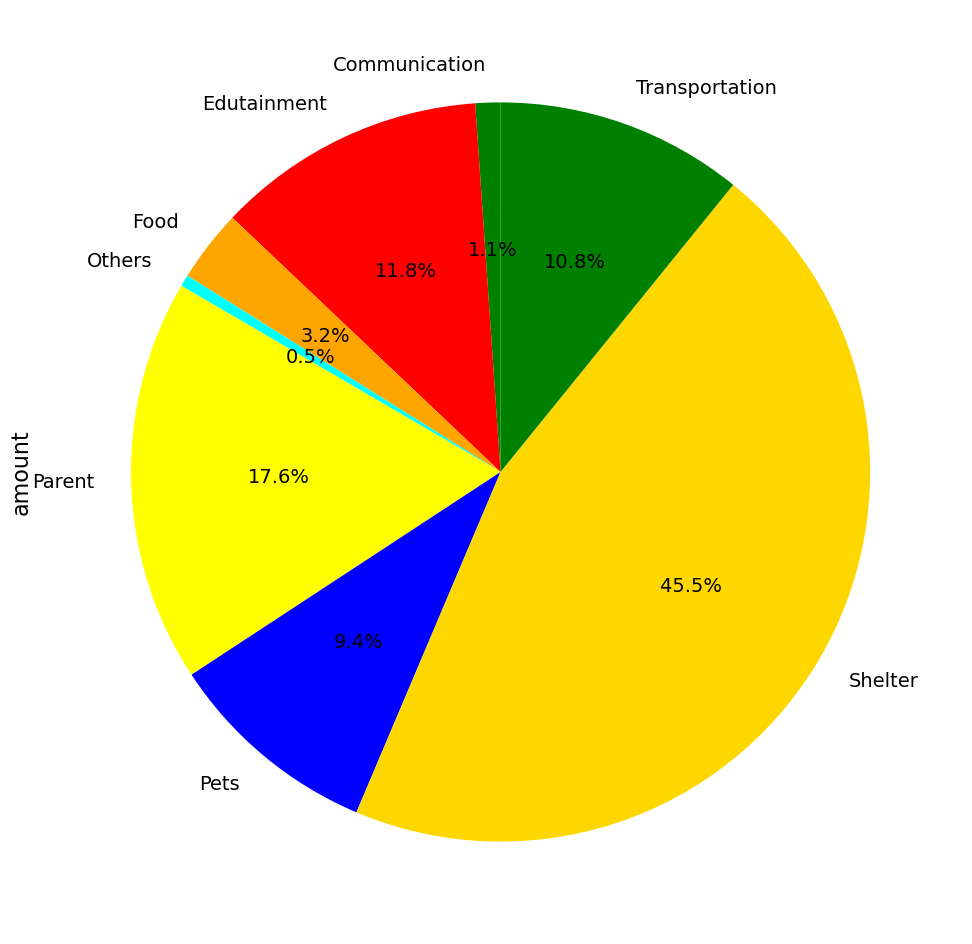

In [47]:
fig_path = "../fig/Expense-2502.png"
with plt.style.context("my_custom_style"):
    plt.figure(figsize=(12, 12))
    ax = expense.plot.pie(
        colors=["green", "red", "orange", "cyan", "yellow", "blue", "gold"],
        startangle=90,
        autopct="%1.1f%%",
    )
    plt.savefig(fig_path)
    plt.show()

In [49]:
expense.to_csv("../data/expense-2502.csv")

In [51]:
sql = """
SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE date = "%s" 
ORDER BY date
"""
sql = sql % (eom)
print(sql)


SELECT date,amount,C.name AS item, G.name AS kind FROM transactions T 
JOIN categories C ON category_id = C.id 
JOIN groups G ON group_id = G.id 
WHERE date = "2025-02-28" 
ORDER BY date



In [53]:
df_tmp = pd.read_sql(sql, conn)
show(df_tmp[['date','amount','item','kind']])

In [55]:
df_tmp.to_csv("../data/expense-eom.csv")

In [57]:
sql = "SELECT * FROM groups"
groups = pd.read_sql(sql, conn)
groups.dtypes

id             int64
name          object
created_at    object
updated_at    object
factor4       object
dtype: object

In [59]:
groups

,id,name,created_at,updated_at,factor4
0,1,Apparel,2016-01-01 13:38:53.119230,2016-01-01 13:38:53.119230,2
1,2,Communication,2016-01-01 13:38:53.199234,2016-01-01 13:38:53.199234,5
2,3,Edutainment,2016-01-01 13:38:53.289240,2016-01-01 13:38:53.289240,6
3,4,Food,2016-01-01 13:38:53.356243,2016-01-01 13:38:53.356243,1
4,5,Luxury,2016-01-01 13:38:53.422247,2016-01-01 13:38:53.422247,6
5,6,Medicine,2016-01-01 13:38:53.498252,2016-01-01 13:38:53.498252,4
6,7,Others,2016-01-01 13:38:53.564255,2016-01-01 13:38:53.564255,6
7,8,Parent,2016-01-01 13:38:53.622259,2016-01-01 13:38:53.622259,7
8,9,Shelter,2016-01-01 13:38:53.689263,2016-01-01 13:38:53.689263,3
9,10,Transportation,2016-01-01 13:38:53.764267,2016-01-01 13:38:53.764267,5


In [61]:
sql = "SELECT * FROM categories"
categories = pd.read_sql(sql, conn)
categories.dtypes

id             int64
sequence       int64
name          object
default        int64
group_id       int64
created_at    object
updated_at    object
dtype: object

In [63]:
categories

,id,sequence,name,default,group_id,created_at,updated_at
0,1,4,Books & Software,0,3,2016-01-01 14:34:11.909054,2016-01-01 14:34:11.909054
1,2,19,CCF,600,5,2016-01-01 14:34:11.976058,2016-01-01 14:34:11.976058
2,3,2,Cigarette,0,5,2016-01-01 14:34:12.067063,2016-01-01 14:34:12.067063
3,4,1,Food,0,4,2016-01-01 14:34:12.148068,2016-01-01 14:34:12.148068
4,5,3,Fuel,0,10,2016-01-01 14:34:12.209071,2016-01-01 14:34:12.209071
...,...,...,...,...,...,...,...
38,39,76,Netflix,420,3,2022-06-30 15:12:52,2022-06-30 15:12:52
39,40,77,ChatGPT,690,3,2023-03-31 16:02:59,2023-03-31 16:02:59
40,41,78,MidJourney,350,3,2023-03-31 16:03:46,2023-03-31 16:03:46
41,42,79,Yearly Norton,1990,3,2023-09-03 08:17:21,2023-09-03 08:17:21


In [65]:
sql = "SELECT * FROM transactions"
transactions = pd.read_sql(sql, conn)
transactions.dtypes

id              int64
date           object
category_id     int64
amount          int64
created_at     object
updated_at     object
dtype: object

In [67]:
transactions.tail()

,id,date,category_id,amount,created_at,updated_at
3015,3051,2025-02-28,39,420,2025-02-28 14:14:19.070947,2025-02-28 14:14:19.070947
3016,3052,2025-02-28,12,320,2025-02-28 14:14:53.049147,2025-02-28 14:14:53.049147
3017,3053,2025-02-28,32,170,2025-02-28 14:15:09.133246,2025-02-28 14:15:09.133246
3018,3054,2025-02-28,30,240,2025-02-28 14:15:32.903353,2025-02-28 14:15:32.903353
3019,3055,2025-02-28,30,700,2025-02-28 14:15:41.274364,2025-02-28 14:15:41.274364
